In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Museums'][df1['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Sorry no - read the Bradt Guide']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['sorry', 'no', 'read', 'the', 'bradt', 'guide']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['sorry', 'no', 'read', 'the', 'bradt', 'guide']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['read']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('read', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"go" + 0.071*"worth" + 0.067*"bit" + 0.059*"ancestor" + 0.055*"give" '
  '+ 0.044*"way" + 0.027*"eye" + 0.027*"insightful" + 0.023*"curate" + '
  '0.017*"confusing"'),
 (1,
  '0.146*"little" + 0.029*"closed" + 0.029*"lonely" + 0.015*"remembrance" + '
  '0.015*"deserve" + 0.015*"attention" + 0.015*"tale" + 0.015*"rate" + '
  '0.015*"underwhelme" + 0.015*"thing"'),
 (2,
  '0.155*"see" + 0.123*"much" + 0.100*"history" + 0.050*"learn" + '
  '0.050*"information" + 0.042*"else" + 0.026*"historical" + 0.021*"tough" + '
  '0.021*"emotionally" + 0.021*"heavy"'),
 (3,
  '0.107*"history" + 0.087*"dark" + 0.074*"informative" + 0.047*"chapter" + '
  '0.047*"gem" + 0.047*"recent" + 0.039*"important" + 0.032*"presentation" + '
  '0.021*"appropriate" + 0.021*"uncensored"'),
 (4,
  '0.075*"hide" + 0.059*"different" + 0.045*"close" + 0.034*"still" + '
  '0.029*"visit" + 0.029*"hour" + 0.029*"somewhat" + 0.029*"forget" + '
  '0.025*"reality" + 0.018*"story"'),
 (5,
  '0.189*"history" + 0.06

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.625645760659661

Coherence Score:  0.5865694197868939


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('history', 0.43333333333333335),
   ('difficult', 0.1),
   ('happen', 0.03333333333333333),
   ('derg', 0.03333333333333333),
   ('cover', 0.03333333333333333),
   ('secret', 0.03333333333333333),
   ('eye', 0.03333333333333333),
   ('visual', 0.03333333333333333),
   ('school', 0.03333333333333333),
   ('tale', 0.03333333333333333)]),
 (1,
  [('history', 0.21875),
   ('worth', 0.15625),
   ('presentation', 0.09375),
   ('tough', 0.0625),
   ('closed', 0.0625),
   ('surprisingly', 0.03125),
   ('unknown', 0.03125),
   ('gruesome', 0.03125),
   ('human', 0.03125),
   ('reflect', 0.03125)]),
 (2,
  [('information', 0.17391304347826086),
   ('informative', 0.15217391304347827),
   ('learn', 0.13043478260869565),
   ('chill', 0.08695652173913043),
   ('middle', 0.021739130434782608),
   ('chilling', 0.021739130434782608),
   ('history', 0.021739130434782608),
   ('communist', 0.021739130434782608),
   ('building', 0.021739130434782608),
   ('education', 0.021739130434782608)]),
 (

2
3
4
5
6
7
8
9
10


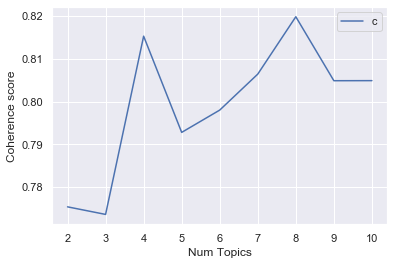

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7754
Num Topics = 3  has Coherence Value of 0.7736
Num Topics = 4  has Coherence Value of 0.8153
Num Topics = 5  has Coherence Value of 0.7928
Num Topics = 6  has Coherence Value of 0.798
Num Topics = 7  has Coherence Value of 0.8064
Num Topics = 8  has Coherence Value of 0.8198
Num Topics = 9  has Coherence Value of 0.8049
Num Topics = 10  has Coherence Value of 0.8049


In [22]:
optimal_model = model_list[6] # Number of Topics = 8

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.184*"informative" + 0.158*"past" + 0.105*"era" + 0.079*"time" + '
  '0.079*"gem" + 0.053*"view" + 0.026*"tale" + 0.026*"derg" + 0.026*"cover" + '
  '0.026*"raw"'),
 (1,
  '0.111*"hard" + 0.089*"important" + 0.067*"presentation" + 0.044*"tough" + '
  '0.044*"depressing" + 0.044*"building" + 0.044*"shape" + 0.044*"period" + '
  '0.044*"small" + 0.022*"lighting"'),
 (2,
  '0.115*"reminder" + 0.096*"bit" + 0.077*"chill" + 0.058*"display" + '
  '0.038*"lonely" + 0.019*"historical" + 0.019*"move" + 0.019*"organize" + '
  '0.019*"real" + 0.019*"chilling"'),
 (3,
  '0.169*"dark" + 0.051*"average" + 0.051*"recent" + 0.051*"difficult" + '
  '0.034*"guide" + 0.034*"curate" + 0.017*"monument" + 0.017*"preserve" + '
  '0.017*"ministerial" + 0.017*"expo"'),
 (4,
  '0.320*"small" + 0.080*"time" + 0.040*"regime" + 0.040*"hide" + '
  '0.040*"forget" + 0.020*"ancestor" + 0.020*"testament" + 0.020*"evidence" + '
  '0.020*"intense" + 0.020*"background"'),
 (5,
  '0.564*"history" + 0.091*"worth" 

In [23]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.187398  0.013531       1        1  12.625866
2     -0.112698 -0.149167       2        1  12.567715
5     -0.219014  0.108687       3        1  12.557349
4      0.232764  0.238598       4        1  12.503035
6      0.082997 -0.207558       5        1  12.488663
7     -0.020609 -0.238628       6        1  12.476457
1     -0.095812  0.261554       7        1  12.402061
0      0.319770 -0.027017       8        1  12.378855, topic_info=    Category       Freq            Term      Total  loglift  logprob
28   Default  36.000000         history  36.000000  30.0000  30.0000
44   Default  22.000000           small  22.000000  29.0000  29.0000
63   Default  11.000000     informative  11.000000  28.0000  28.0000
55   Default  10.000000            dark  10.000000  27.0000  27.0000
38   Default  10.000000     information  10.000000  26.0000  26.0000
48   Default   9.000000            past   9.000000  25.0000  25.0000
2    Default   8.000000          poorly   8.000000  24.0000  24.0000
23   Default   7.000000           learn   7.000000  23.0000  23.0000
57   Default   7.000000        reminder   7.000000  22.0000  22.0000
89   Default   9.000000            time   9.000000  21.0000  21.0000
60   Default   6.000000             era   6.000000  20.0000  20.0000
50   Default   7.000000            hard   7.000000  19.0000  19.0000
12   Default   5.000000             bit   5.000000  18.0000  18.0000
36   Default   5.000000           worth   5.000000  17.0000  17.0000
68   Default   5.000000       important   5.000000  16.0000  16.0000
85   Default   4.000000             gem   4.000000  15.0000  15.0000
34   Default   4.000000           chill   4.000000  14.0000  14.0000
4    Default   4.000000    presentation   4.000000  13.0000  13.0000
46   Default   3.000000           close   3.000000  12.0000  12.0000
79   Default   3.000000         chapter   3.000000  11.0000  11.0000
1    Default   3.000000         display   3.000000  10.0000  10.0000
215  Default   3.000000            view   3.000000   9.0000   9.0000
59   Default   3.000000       difficult   3.000000   8.0000   8.0000
94   Default   3.000000         average   3.000000   7.0000   7.0000
56   Default   3.000000          recent   3.000000   6.0000   6.0000
72   Default   2.000000          period   2.000000   5.0000   5.0000
37   Default   2.000000        building   2.000000   4.0000   4.0000
76   Default   2.000000      depressing   2.000000   3.0000   3.0000
29   Default   2.000000           shape   2.000000   2.0000   2.0000
244  Default   2.000000           tough   2.000000   1.0000   1.0000
..       ...        ...             ...        ...      ...      ...
63    Topic8  11.173545     informative  11.173545   2.0892  -1.6917
60    Topic8   6.384883             era   6.384883   2.0892  -2.2513
48    Topic8   9.577324            past   9.577324   2.0892  -1.8458
41    Topic8   1.596221            bore   1.596221   2.0892  -3.6376
5     Topic8   1.596221           stuff   2.780486   1.5342  -3.6376
139   Topic8   1.596221         exhibit   2.845087   1.5112  -3.6376
86    Topic8   1.596221             raw   2.896958   1.4932  -3.6376
89    Topic8   4.788662            time   9.689852   1.3844  -2.5390
0     Topic8   0.000000            read   1.350447     -inf     -inf
1     Topic8   0.000000         display   3.552796     -inf     -inf
2     Topic8   0.000000          poorly   8.742064     -inf     -inf
3     Topic8   0.000000        interste   1.184265     -inf     -inf
4     Topic8   0.000000    presentation   4.051340     -inf     -inf
6     Topic8   0.000000         visited   1.300737     -inf     -inf
7     Topic8   0.000000       captivate   1.048589     -inf     -inf
8     Topic8   0.000000            keep   0.000000      NaN     -inf
9     Topic8   0.000000            much   0.000000      NaN     -inf
10    Topic8   0.000000        proba

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1422,"hard, important, presentation, tough, depressi...",Sorry no - read the Bradt Guide
1,1,2.0,0.1394,"reminder, bit, chill, display, lonely, histori...",Dusty and poorly displayed
2,2,2.0,0.1410,"reminder, bit, chill, display, lonely, histori...","Intersting stuff, but poor presentation"
3,3,7.0,0.1422,"information, close, chapter, understand, reali...",Shocking but must be visited!
4,4,3.0,0.1400,"dark, average, recent, difficult, guide, curat...",Captivating and shocking
5,5,0.0,0.1250,"informative, past, era, time, gem, view, tale,...","Probably a must see, but not much to keep you ..."
6,6,0.0,0.1394,"informative, past, era, time, gem, view, tale,...",Grace gone a bit down.
7,7,2.0,0.1692,"reminder, bit, chill, display, lonely, histori...",Home to Lucy but overcrowded with Children and...
8,8,0.0,0.1250,"informative, past, era, time, gem, view, tale,...",Hardly world class
9,9,0.0,0.1250,"informative, past, era, time, gem, view, tale,...",Disappointing


In [25]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    92
3.0    27
1.0    26
5.0    22
4.0    21
7.0    21
6.0    20
2.0    20
Name: Dominant_Topic, dtype: int64

In [37]:
df_dominant_topic.to_csv('ethiopia_462.csv', index = False)

In [36]:
# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 92
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expressing Sadness over History - 26
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Museum Curation Criticism - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Expressing Sadness over History - 27
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Expressing Sadness over History - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Museum Curation Criticism - 22
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Museum Curation Criticism - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Accessibility Criticism - 21

In [32]:
# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expressing Disappointment - 109
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Criticizing Museum Curation - 23
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Museum Closed - 17
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Expressing Sadness over History - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Expressing Sadness over History - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Criticizing Museum Curation - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Expressing Sadness over History - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Expressing Sadness over History - 20

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1557,"informative, past, era, time, gem, view, tale,...",Old Bones and views of the past
1,1.0,0.1428,"hard, important, presentation, tough, depressi...","Bad displays, fragmentary information that doe..."
2,2.0,0.1692,"reminder, bit, chill, display, lonely, histori...",Home to Lucy but overcrowded with Children and...
3,3.0,0.1587,"dark, average, recent, difficult, guide, curat...",A Dark Past which is Recent
4,4.0,0.1528,"small, time, regime, hide, forget, ancestor, t...",It is horrible reminder of the bloody regime o...
5,5.0,0.1587,"history, worth, topic, hidden, bone, city, acc...",Terrifying history
6,6.0,0.1557,"poorly, learn, closed, selam, nonetheless, rim...","Visit Lucy and Selam, but everything else is p..."
7,7.0,0.1587,"information, close, chapter, understand, reali...",Dont understand the bad reviews


In [39]:
sent_topics_sorteddf_mallet['Text'].values

array(['Old Bones and views of the past',
       'Bad displays, fragmentary information that does not exceed our middle school education ',
       'Home to Lucy but overcrowded with Children and poor displays',
       'A Dark Past which is Recent',
       'It is horrible reminder of the bloody regime of the Derge regime',
       'Terrifying history',
       'Visit Lucy and Selam, but everything else is poorly organized',
       'Dont understand the bad reviews'], dtype=object)

In [40]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics